# Modeling Lithium Intercalation of a Single Spinel Particle under Potentiodynamic Control

## About

- authors:
    - Dong Zhang
    - Branko N. Popov
    - Ralph E. White
- id:
    ``doi: 10.1149/1.1393279``
- tags:
    - micro
    - spm
- sources:
    - [paper](https://iopscience.iop.org/article/10.1149/1.1393279)

This paper is one of the fundamental papers of single particle based battery modeling.
In this paper a particle of a single halfcell is simulated.
With only one differential equations it is one of the simplest models to start with.

Implementing the model of the paper seems straight forward, but comes with some pitfalls which have been addressed by this implementation.
The paper introduces the unitless concentration $y$, which at the beginning of the simulation (intial condition) is $=1$.
But the function of the open-circuit potential $U_{ocp}$ is singluar for $y$-values greater or equal to $y_{max} = 0.998432$.
This implementions goes arround the problem by using a linear function for $y >= y_{max}$  (Taylor expension).
Nevertheless $y$-values equal to 1 are still a problem, because the ion flux $j$ will be always zero.

# Setup

This notebooks requires the following packages:
- [diffeq](https://pypi.org/project/diffeqpy/) - optional for more differential equation solvers (for more details see the [other solvers](#(optional)-other-solvers) section)
- [matplotlib](https://pypi.org/project/matplotlib/) - plotting of the results
- [numpy](https://pypi.org/project/numpy/) - required for all the numerical operations
- [scikit-fem](https://pypi.org/project/scikit-fem/) - compute simple FEM 
- [scipy](https://pypi.org/project/scipy/) - solves the differential equation
- [polars](https://pypi.org/project/polars/) - stores and read the date from a ``.json``-file (theoretically not required)


All dependecies can be automatically be installed, if:
````python
automated_setup = True
````

**Note:** that the notebook will install the required packages for a ``python 3.10`` kernel.
But the code can simply be adapted to other kernels.

In [1]:
automated_setup = False
store_images = False
strategy = [
    "default",
    "lin_extension"
][0]

mod_imperfection = [
    0, 
    (1 - 1e-4), # default (best results)
    0.996016
][2]

mod_ocp = [
    "lin_ext", # default (best results)
    "without_ext"
][1]

from pathlib import Path

version = ("v_" + str(mod_imperfection).replace(".", "d")[:6] + "_" + mod_ocp)
version = "test"
result_path = Path.cwd() / "sol_spm" / version
if not result_path.exists():
    result_path.mkdir()

In [2]:
%matplotlib inline

In [3]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'text.usetex': True,
    'pgf.rcfonts': False,
})

### Automated Install

make sure the Python-Version is correct

In [4]:
import sys
print(sys.version)

3.10.11 (main, Apr  5 2023, 00:00:00) [GCC 13.0.1 20230404 (Red Hat 13.0.1-0)]


In [5]:
%%capture
if automated_setup:
    ! python3.10 -m pip install --upgrade pip
    ! python3.10 -m pip install numpy
    ! python3.10 -m pip install matplotlib
    ! python3.10 -m pip install scipy
    ! python3.10 -m pip install scikit-fem
    ! python3.10 -m pip install polars

## Material data

In [6]:
import numpy as np

const = {
    "R": 8.314472,    # [m^2 kg s^-2 K^-1 mol^-1]
    "F":96485.3415,   # [m^2 kg s^-2 K^-1 mol^-1]
    "T":25 + 273.15,  # [°C] -> [K]
    "dU/dt": 1 * 1e-3    # "nu" [mV s^-1] -> [V s^-1]
}

electrode = {
    "D": 2.2e-9 * 1e-4, # [cm^2 s^-1] -> [m^2 s^-1]
    "Rs": 5e-4 * 1e-2, # [cm] -> [m]
    "c_max": 23.7 * 1e3, # [mol dm^-3] -> [mol m^-3]
    "k": 0.00019 * np.power(1e-2, (5 / 2)), # [cm^(5/2) s^-1 mol^(-1/2)] -> [m^(5/2) s^-1 mol^(-1/2)]
    "beta": 0.5, # []
}

electrolyte = {
    # "c_ini": 1.0 * 1e3, # [mol dm^-3] -> [mol m^-3]
    "c_max": 1.0 * 1e3, # [mol dm^-3] -> [mol m^-3]
}

electrode["c_ini"] = mod_imperfection * electrode["c_max"] # adding imperfection

The imperfection of the intiial concentration of the electrode is required, due to the Volmer-Butler-Equation beeing zero in this case no matter the current over-potential.

## Open-Circuit-Potential (OCP)

In [7]:
def U_ocp(y_s):
    """
    The open-circuit potential as a function of the dimensionaless
    concentration of lithium-ions at the surface of the manganese dioxide particle
    """
    y_s_max = 0.998432
    return (
        4.19829
        + 0.0565661 * np.tanh(-14.5546 * y_s + 8.60942)
        - 0.0275479 * (np.power(abs(y_s_max - y_s), -0.492465) - 1.90111)
        - 0.157123 * np.exp(-0.04738 * np.power(y_s, 8))
        + 0.810239 * np.exp(-40.0 * y_s + 5.355)
    )

For numerical stability it is important to have a function which is defined for values greater $\mathrm{y_{max}}$.
Therefore, a linear expansion for values close to $\mathrm{y_{max}}$ was added (see: ``U_ocp_ext(y_s)``)

In [8]:
def U_ocp_ext(y_s, dy=0.006360215613507735):  # 22e-4
    y_s_max = 0.998432
    if y_s >= y_s_max - dy:
        c = y_s_max - dy
        h = 1e-6
        U_ocp_max = U_ocp(y_s_max - dy)
        U_ocp_max_h = U_ocp(y_s_max - dy - h)
        return U_ocp_max + (U_ocp_max - U_ocp_max_h) / (h) * (y_s - c)
    return U_ocp(y_s)

### (Optional) Optical Comparison

Both open-circuit potentials are plotted.
This is helpful for debugging and illustrating purposes.

In [9]:
x_min = 0.18
x_break = 0.998431 # litte bit les then y_s_max
x_max = 1.0

y_paper = np.linspace(x_min, x_break, 1000)
U_paper = np.zeros(len(y_paper))
for i in range(len(y_paper)):
    U_paper[i] = U_ocp(y_paper[i])

y_ext = np.linspace(x_break, x_max, 10)
U_ext = np.zeros(len(y_ext))
for i in range(len(y_ext)):
    U_ext[i] = U_ocp_ext(y_ext[i])

import uocps
y_plett = np.linspace(x_min, x_max-1/1000, 1000)
U_plett = np.zeros(len(y_plett))
for i in range(len(y_plett)):
    U_plett[i] = uocps.U_ocp("LMO",y_plett[i])


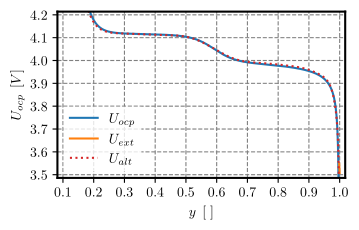

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from helpers import set_size


fig,ax = plt.subplots(figsize=set_size(245))

ax.plot(y_paper, U_paper, label=r"$U_{ocp}$")
ax.plot(y_ext, U_ext, label=r"$U_{ext}$")
ax.plot(y_plett, U_plett, label=r"$U_{alt}$", linestyle='dotted', color="#d62728")

ax.xaxis.grid(which='both', color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_xlabel(r"$y \; \left[ \; \right]$")
ax.set_ylabel(r"$U_{ocp} \; \left[ V \right]$")
ax.legend(loc='lower left', 
          edgecolor='white',
          fancybox=False, frameon=True)


x_min = np.floor(0.1 * 10) / 10
x_max = np.ceil(1.0 * 10) / 10
dx = x_max - x_min

minor_locator = AutoMinorLocator(1)
ax.xaxis.set_minor_locator(minor_locator)
ax.set_xticks(np.arange(x_min, x_max + 0.1,0.1))
ax.set_xlim([x_min - dx * 0.02, x_max + dx * 0.02])

y_min = 3.5
y_max = 4.2
dy = y_max - y_min
ax.set_yticks(np.arange(y_min, y_max + 0.1, 0.1))
ax.set_ylim([y_min - dy * 0.02, y_max + dy * 0.02])

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_color('black')  
    ax.spines[axis].set_linewidth(1.5)  

# This should be called after all axes have been added
fig.tight_layout(pad=0)

if store_images:
    plt.savefig(result_path / 'spm_zhang_Uocp(y).pgf')

fig

## Applied Potential

An external potential is applied to the halfcell.
The potential starts with the potential of the fully charged cell and discharges the battery by increasing the potential with a constant value over time.
After a short holding period, this process is reversed.

In [11]:
y_max = electrode["c_ini"]/ electrode["c_max"]
U_start = 0

if mod_ocp == "without_ext":
    U_start = U_ocp(y_max) 
else:
    U_start = U_ocp_ext(y_max) 

U_max = 4.3102  # [V]
t_change = (U_max-U_start) / const["dU/dt"]
t_hold = t_change *0.1
t_period = 2*(t_change + t_hold)
t_end = (
        t_change # discharge
        + t_hold 
        + t_change  # charge
    )

def U_app(t):
    t_rel = t % t_period
    if t_rel <= t_change:
        return U_start + t_rel * const["dU/dt"]
    elif t_rel - t_change <= t_hold:
        return U_max
    elif t_rel - (t_change + t_hold) <= t_change:
        return U_max - (t_rel - t_change - t_hold) * const["dU/dt"]
    else:
        return U_start

### (Optional) The Applied Voltage Curve

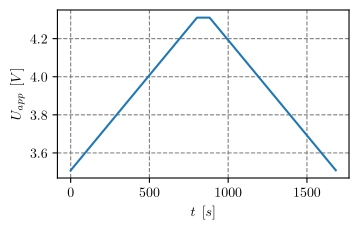

In [12]:

ts = np.arange(t_end)
u_apps = [U_app(t) for t in ts]

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from helpers import set_size


fig,ax = plt.subplots(figsize=set_size(245))

ax.plot(ts, u_apps, label=r"$U_{app}$")

ax.xaxis.grid(which='both', color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_xlabel(r"$t \; \left[ s \right]$")
ax.set_ylabel(r"$U_{app} \; \left[ V \right]$")

fig.tight_layout(pad=0)

if store_images:
    plt.savefig(result_path / 'spm_zhang_Uapp(t).pgf')

fig

## Butler-Volmer-Equation

The Butler-Volmer-Equation can be used to describe the ion flux over the particle surface.

In [13]:
def j_eta(c_surf:float, eta:float):
    """_summary_

    Parameters
    ----------
    c_surf : float
        concentration on particle surface [mol/m^3]

    eta : float
        over potential [V]

    Returns
    -------
    float
        ion flux in [A/m^2]/[A*s/mol] = [mol/m^2/s]
    """
    j0 = (
        electrode["k"] 
        * np.power(electrolyte["c_max"], 1 - electrode["beta"]) 
        * np.power(electrode["c_max"] - c_surf, 1 - electrode["beta"]) 
        * np.power(c_surf, electrode["beta"])
    )

    j = j0 * (
        np.exp(((1 - electrode["beta"]) * const["F"] * eta) / (const["R"] * const["T"]))
        - np.exp(-1 * (electrode["beta"] * const["F"] * eta) / (const["R"] * const["T"]))
    )

    return j

The overpotential can be simplified with:
$$\eta = U_app(t) - U_{ocp}(c_{surf}).$$
Resulting in ``ion_flux(c_surf, u_app)``

In [14]:
if mod_ocp == "without_ext":
    def ion_flux(c_surf: float, u_app: float):
        eta = u_app - U_ocp(c_surf / electrode["c_max"])
        return j_eta(c_surf, eta)
else:
    def ion_flux(c_surf: float, u_app: float):
        eta = u_app - U_ocp_ext(c_surf / electrode["c_max"])
        return j_eta(c_surf, eta)

### (Optional) Visualization

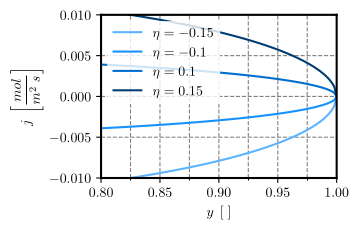

In [15]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

x_min = 0.8
x_max = 1.0
y = np.linspace(x_min, x_max, 100)
etas = [-0.15, -0.1, 0.1, 0.15]
colors = [
    "#5cb3ff", "#1692ff", "#006ecf", "#003c71", 
    ]

fig,ax = plt.subplots(figsize=set_size(245))

y_min = 0
y_max = 0
for i in range(len(etas)):
    eta = etas[i]
    j = j_eta(y*electrode["c_max"], eta)
    ax.plot(
            y,
            j,
            label=r"$\eta=" + str(eta) + "$",
            color=colors[i]
        )
    y_min = np.minimum(y_min, np.min(j))
    y_max = np.maximum(y_min, np.max(j))

ax.xaxis.grid(which='both', color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_xlabel(r"$y \; \left[ \; \right]$")
ax.set_ylabel(r"$j \; \left[ \frac{mol}{m^2 \; s} \right]$")
ax.legend(loc='upper left', 
          edgecolor='white',
          fancybox=False, frameon=True)


dx = 0.05
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.set_xticks(np.arange(x_min, x_max + dx, dx))
ax.set_xlim([x_min, x_max])

n_decimals = 3
shift = 10**n_decimals
y_min = np.ceil(y_min * shift) / shift
y_max = np.floor(y_max * shift) / shift

dy = np.ceil((y_max - y_min)/4 * shift) / shift

ax.set_yticks(np.arange(y_min, y_max + dy, dy))
ax.set_ylim([y_min, y_max])

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_color('black')  
    ax.spines[axis].set_linewidth(1.5)  

# This should be called after all axes have been added
fig.tight_layout(pad=0)

if store_images:
    plt.savefig(result_path / 'spm_zhang_j(y).pgf')

fig

## FEM

In [16]:
from skfem import MeshLine

n_nodes = 20 + 1
space = np.linspace(0, 1, n_nodes)
mesh = MeshLine(space).with_boundaries(
    {"inner": lambda xi: xi[0] == 0, "surface": lambda xi: xi[0] == 1.0}
)

In [17]:
from skfem import Basis, ElementLineP2

basis = Basis(mesh, ElementLineP2())  # ElementLineHermite
basis_surf = basis.boundary("surface")

In [18]:
from skfem import  BilinearForm, LinearForm
from skfem.helpers import dot, grad

@BilinearForm
def M(c, v, w):
    r = w.x[0]
    return r**2 * electrode["Rs"] * c * v


@BilinearForm
def A(c, v, w):
    r = w.x[0]
    return electrode["D"] * r**2 / electrode["Rs"] * dot(grad(c), grad(v))


@LinearForm
def b(v, w):
    return dot(w.n, v)

In [19]:
Mass = M.assemble(basis)
Fick = A.assemble(basis)
bc = b.assemble(basis_surf)

In [20]:
Mass_inv = np.linalg.pinv(Mass.toarray())

In [21]:
def get_c_surf(us):
    return us[basis.get_dofs("surface")]

In [22]:
def sort_u_by_x(basis, u):
    x_coords = basis.doflocs[0] # [0, 1, 0.25, 0.5, 0.75]
    indeces = [i for i in range(len(x_coords))] # [0, 1, 2, 3, 4]
    indeces_by_x = [id for _,id in sorted(zip(x_coords, indeces))] # [0, 4, 1, 2, 3]
    x_sorted = np.sort(x_coords) # [0, 0.25, 0.5, 0.75, 1]
    res = [u[i] for i in indeces_by_x] # [u_0, u_0.25, u_0.5, u_0.75, u_1]
    return (x_sorted, res)

## Problem

setting the intial values

In [23]:
def inital(x):
    return np.ones((x.shape[1], x.shape[2])) * electrode["c_ini"]

u0 = basis.project(inital)

To solve the problem the solver requires the problem to be written in the following form:
$$func(t, u) \mapsto \frac{\partial u}{ \partial t}.$$
For the problem from Zhang et. al. the $u = c$.
As mentioned earlier the Problem written in FEM looks like:
$$M.\frac{\partial c}{ \partial t} = -j * bc - F.c,$$
with $M$-the mass matrix, $F$- the diffusion matrix derived from Fick's law and $bc$- the vector of the Neumann boundary condition on the surface.
To get the required form one has to simply multiply with the inverse of $M$:
$$\frac{\partial c}{ \partial t} = M^{-1}.(-j * bc - F.c)$$
and the problem is finished.



In [24]:
def zhang(t, u):
    j = ion_flux(get_c_surf(u), U_app(t))
    return np.matmul(Mass_inv, (-j * bc - Fick.dot(u)))

## Solve

In [25]:
from scipy.integrate import solve_ivp

tspan = [0.0, t_end]

sol = solve_ivp(
    zhang,
    tspan,
    u0,
    method="Radau",  # Radau, BDF, LSODA
    # atol=1e-6,

    # crucial because applied potential current can change each second
    max_step= 1, 
    dense_output=True,
)

/tmp/ipykernel_68637/3039265843.py:12: RuntimeWarning: overflow encountered in exp
  + 0.810239 * np.exp(-40.0 * y_s + 5.355)
/tmp/ipykernel_68637/442130318.py:21: RuntimeWarning: invalid value encountered in power
  * np.power(c_surf, electrode["beta"])
/tmp/ipykernel_68637/442130318.py:20: RuntimeWarning: invalid value encountered in power
  * np.power(electrode["c_max"] - c_surf, 1 - electrode["beta"])


In [26]:
import numpy as np


ts = np.linspace(0, t_end, 2000)
c_sol = sol.sol(ts).T

u_apps = np.zeros(len(ts))
js = np.zeros(len(ts))
c_surfs = np.zeros(len(ts))

for i in range(len(ts)):
    u_apps[i] = U_app(ts[i])
    c_li = c_sol[i]
    c_surf = get_c_surf(c_li)
    c_surfs[i] = c_surf
    js[i] = ion_flux(c_surf, u_apps[i])

Is = js * const["F"] * 4 * np.pi * electrode["Rs"]**2
js = js * (electrode["Rs"] / (electrode["D"] * electrode["c_max"])) # dimensionless j []

import polars as pl

df = pl.DataFrame({
    "t": ts,
    "j": js,
    "I": Is,
    "U": u_apps,
    "c_surf":  c_surfs,
})

# write to file
from pathlib import Path 

storageFile = result_path / "sol_zhang.json"
print(storageFile.absolute())
df.write_json(storageFile)

/home/willi/Documents/devel/battery/sol_spm/v_0d9960_without_ext/sol_zhang.json


## (Optional) Other Solvers

``diffeq`` is a package that is specialized on solving differential equations.
While it has access to more solvers, the package utilizes libraries from the ``julia`` language.
Therefore a more advanced setup is required:

**Note:** ``julia`` has to be installed manually before continuing with the next steps!

In [27]:
use_julia = False

In [28]:
if use_julia and automated_setup:
    ! python3.10 -m pip install julia
    import julia
    julia.install()
    ! python3.10 -m pip install diffeqpy

### ODE-Solver

In [29]:
def zhang_ode (u, p, t):
    j = ion_flux(get_c_surf(u), U_app(t))
    return np.matmul(Mass_inv, (-j * bc - Fick.dot(u)))

In [30]:
if use_julia:
    from diffeqpy import de
    prob = de.ODEProblem(zhang_ode, u0, tspan)
    # prob = de.DAEProblem(spm_dae, du0,u0, tspan, params, differential_vars=differential_vars)
    sol_ode = de.solve(prob, reltol = 1e-8, abstol = 1e-8)

In [31]:
import numpy as np


if use_julia:
    ts    = sol_ode.t
    c_sol = sol_ode.u

    u_apps  = np.zeros(len(ts))
    js      = np.zeros(len(ts))
    c_surfs = np.zeros(len(ts))

    for i in range(len(ts)):
        u_apps[i] = U_app(ts[i])
        c_li = c_sol[i]
        c_surf = get_c_surf(c_li)
        c_surfs[i] = c_surf
        js[i] = ion_flux(c_surf, u_apps[i])

    Is = js * const["F"] * 4 * np.pi * electrode["Rs"]**2
    js = js * (electrode["Rs"] / (electrode["D"] * electrode["c_max"])) # dimensionless j []

    import polars as pl

    df = pl.DataFrame({
        "t": ts,
        "j": js,
        "I": Is,
        "U": u_apps,
        "c_surf":  c_surfs,
    })

    # write to file
    from pathlib import Path 

    storageFile = result_path / "sol_zhang_ode.json"
    print(storageFile.absolute())
    df.write_json(storageFile)

### DAE-Solver

In [32]:
def zhang_dae(du, u, p, t):
    j = ion_flux(get_c_surf(u), U_app(t))
    return (-j * bc - Fick.dot(u)) - Mass.dot(du)

In [33]:
if use_julia:
    from diffeqpy import de
    du0 = np.zeros(len(u0))
    differential_vars = [True] * len(u0)
    prob = de.DAEProblem(zhang_dae, du0, u0, tspan, differential_vars=differential_vars)
    # prob = de.DAEProblem(spm_dae, du0,u0, tspan, params, differential_vars=differential_vars)
    sol_dae = de.solve(prob, reltol = 1e-8, abstol = 1e-8)

In [34]:
import numpy as np


if use_julia:
    ts    = sol_dae.t
    c_sol = sol_dae.u

    u_apps  = np.zeros(len(ts))
    js      = np.zeros(len(ts))
    c_surfs = np.zeros(len(ts))

    for i in range(len(ts)):
        u_apps[i] = U_app(ts[i])
        c_li = c_sol[i]
        c_surf = get_c_surf(c_li)
        c_surfs[i] = c_surf
        js[i] = ion_flux(c_surf, u_apps[i])

    Is = js * const["F"] * 4 * np.pi * electrode["Rs"]**2
    js = js * (electrode["Rs"] / (electrode["D"] * electrode["c_max"])) # dimensionless j []

    import polars as pl

    df = pl.DataFrame({
        "t": ts,
        "j": js,
        "I": Is,
        "U": u_apps,
        "c_surf":  c_surfs,
    })

    # write to file
    from pathlib import Path 

    storageFile = result_path / "sol_zhang_dae.json"
    print(storageFile.absolute())
    df.write_json(storageFile)

## Results

In [35]:
from pathlib import Path
import polars as pl

variants = ["zhang", "zhang_ode", "zhang_dae"]
curr_variant = variants[0]

storageFile = result_path / ("sol_" +  curr_variant + ".json")
print(storageFile.absolute())
df = pl.read_json(storageFile)

/home/willi/Documents/devel/battery/sol_spm/v_0d9960_without_ext/sol_zhang.json


In [36]:
Us = df.get_column("U").view()
ts = df.get_column("t").view()
Is = df.get_column("I").view()
js = df.get_column("j").view()

### Plotting j(U_app)

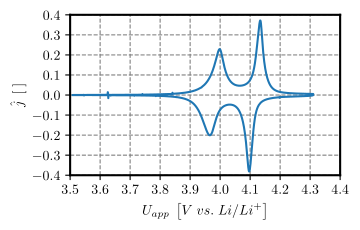

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from helpers import set_size

fig,ax = plt.subplots(figsize=set_size(245))

ax.plot(Us, js)

ax.xaxis.grid(which='both', color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_xlabel(r"$U_{app} \; \left[ V \; vs. \; Li/Li^+\right]$")
ax.set_ylabel(r"$\hat{j} \; \left[ \; \right]$")

import numpy as np

x_min = np.floor(U_start * 10) / 10
x_max = np.ceil(U_max * 10) / 10
dx = x_max - x_max
delta_x = 0.1

minor_locator = AutoMinorLocator(1)
ax.xaxis.set_minor_locator(minor_locator)
ax.set_xticks(np.arange(x_min, x_max + delta_x, delta_x))
ax.set_xlim([x_min, x_max])

y_min = np.floor(np.min(js) * 10) / 10
y_max = np.ceil(np.max(js) * 10) / 10
dy = y_max - y_min
delta_y = 0.1
minor_locator = AutoMinorLocator(1)
ax.yaxis.set_minor_locator(minor_locator)
ax.set_yticks(np.arange(y_min, y_max + delta_y, delta_y))
ax.set_ylim([y_min, y_max])

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_color('black')  
    ax.spines[axis].set_linewidth(1.5) 


fig.tight_layout(pad=0)

if store_images:
    plt.savefig(result_path / ("sol_" + curr_variant + "_j(Uapp).pgf"))

fig

## Animations

In [38]:
# used to stop here
raise RuntimeError

RuntimeError: 

### Animating c_Li(x, t)

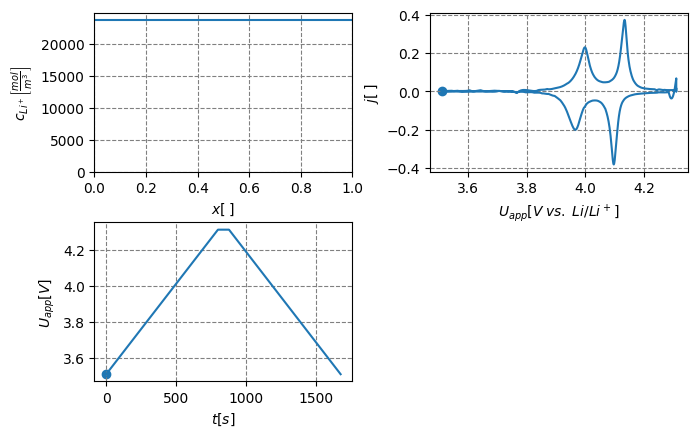

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from helpers import set_size


time_scale = 4
fig,ax = plt.subplots(2,2, figsize=set_size(490))

xs, ys = sort_u_by_x(basis,c_sol[0])
line_c = ax[0,0].plot(xs, ys)[0]
scat_j = ax[0,1].scatter(u_apps[0], js[0])
scat_U = ax[1,0].scatter(ts[0], u_apps[0])

# Axis
img = ax[0,0]
img.xaxis.grid(which='both', color='gray', linestyle='dashed')
img.yaxis.grid(color='gray', linestyle='dashed')

img.set_xlabel(r"$x \left[ \; \right]$")
img.set_ylabel(r"$c_{Li^+} \left[ \frac{mol}{m^3} \right]$")
img.set(xlim=[0, 1], ylim=[0.0*electrode["c_max"], 1.05*electrode["c_max"]])

# j(U_app)
img = ax[0,1]
img.plot(u_apps, js)
img.xaxis.grid(which='both', color='gray', linestyle='dashed')
img.yaxis.grid(color='gray', linestyle='dashed')

img.set_xlabel(r"$U_{app} \left[ V \; vs. \; Li/Li^+\right]$")
img.set_ylabel(r"$j \left[ \; \right]$")

# U_app(t)
img = ax[1,0]
img.plot(ts, u_apps, label=r"$U_{app}$")

img.xaxis.grid(which='both', color='gray', linestyle='dashed')
img.yaxis.grid(color='gray', linestyle='dashed')

img.set_xlabel(r"$t \left[ s \right]$")
img.set_ylabel(r"$U_{app} \left[ V \right]$")


img = ax[1,1]
img.axis('off')

fig.tight_layout(pad=0)

def update(frame):
    frame_id = int(frame * time_scale)
    t = ts[frame_id]
    xs, ys = sort_u_by_x(basis,c_sol[frame_id])
    line_c.set_ydata(ys)
    scat_j.set_offsets([u_apps[frame_id], js[frame_id]])
    scat_U.set_offsets([ts[frame_id], u_apps[frame_id]])
    return line_c, scat_j, scat_U

import matplotlib.animation as animation
ani = animation.FuncAnimation(fig=fig, func=update, frames=int(len(ts)/time_scale), interval=30)
ani.save(filename="sol_zhang.mp4", writer="ffmpeg")

from IPython.display import HTML
HTML(ani.to_html5_video())